In [1]:
import matplotlib.pyplot as plt
import random

from collections import defaultdict

In [2]:
N = 2**16 - 1
N

65535

# Cyclotomic cosets modulo $N$ over $GF(2)$

In [3]:
cyclotomic_cosets = []
used = [False for _ in range(N)]
for s in range(N):
    if used[s]:
        continue
    used[s] = True
    coset = [s]
    cur_elem = (s * 2) % N
    while cur_elem != s:
        coset.append(cur_elem)
        used[cur_elem] = True
        cur_elem = (cur_elem * 2) % N
    # coset.sort()
    cyclotomic_cosets.append(coset)
cyclotomic_cosets[:3]

[[0],
 [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768],
 [3,
  6,
  12,
  24,
  48,
  96,
  192,
  384,
  768,
  1536,
  3072,
  6144,
  12288,
  24576,
  49152,
  32769]]

In [4]:
cyclotomic_coset_size_cnt = defaultdict(int)
cyclotomic_cosets_by_size = defaultdict(list)
for coset in cyclotomic_cosets:
    cyclotomic_coset_size_cnt[len(coset)] += 1
    cyclotomic_cosets_by_size[len(coset)].append(coset)

sum_cnt = 0
for k, v in sorted(cyclotomic_coset_size_cnt.items()):
    sum_cnt += k * v
    print(k, ":", v)
sum_cnt

1 : 1
2 : 1
4 : 3
8 : 30
16 : 4080


65535

In [5]:
print(cyclotomic_cosets_by_size[1])
print(cyclotomic_cosets_by_size[2])
print(cyclotomic_cosets_by_size[4])

[[0]]
[[21845, 43690]]
[[4369, 8738, 17476, 34952], [13107, 26214, 52428, 39321], [30583, 61166, 56797, 48059]]


In [6]:
leaders_8 = list(map(str, sorted([min(coset) for coset in cyclotomic_cosets_by_size[8]])))
print("{" + ', '.join(leaders_8) + "}")

{257, 771, 1285, 1799, 2313, 2827, 3341, 3855, 4883, 5397, 5911, 6425, 6939, 7453, 7967, 9509, 10023, 11051, 11565, 12079, 13621, 14135, 15163, 15677, 16191, 22359, 23387, 24415, 28527, 32639}


# Field $GF(2^{16})$

In [7]:
# F.<a> = GF(2^16, modulus="primitive")
# F

In [8]:
_F.<t> = GF(2)[]
F.<a> = GF(2^16, modulus=(t^16 + t^5 + t^3 + t^2 + 1))
F

Finite Field in a of size 2^16

In [9]:
for i in range(1, N + 1):
    if a^i == 1:
        print(i)

65535


In [10]:
R.<x> = F[]
R

Univariate Polynomial Ring in x over Finite Field in a of size 2^16

# Normal basises of subfileds $GF(2^{m_s}) \subset GF(2^{16})$

### $s2^{m_s} = s \implies \left\{ \alpha^s, \alpha^{s2}, \dots, \alpha^{s2^{m_s-1}} \right\} \subset GF(2^{m_s}) - \text{is a normal basis ??? SEEMS NO}$

### $a^s \in GF(2^{m_s}) - \text{is a primitive element ???}$

In [11]:
def poly16_to_integer(poly):
    if poly == 0 or poly == 1:
        return poly
    poly_i = 0
    for i in range(16):
        if poly[i] == 1:
            poly_i += 1 << i
    return poly_i

In [12]:
def is_normal_basis_gen_of_subfield_f(gen, m, subfield_elems):
    assert len(subfield_elems) == 2^m
    
    normal_basis = [gen^(2^i) for i in range(m)]
    if sum(normal_basis) != 1:
        return False
    
    already_built = defaultdict(lambda: False)
    for repr_i in range(2^m):
        repr_arr = [1 if repr_i & (1 << t) != 0 else 0 for t in range(m)]
        elem = sum(repr_arr[t] * b for t, b in enumerate(normal_basis))
        if already_built[elem]:
            return False
        already_built[elem] = True
    
    return True

In [13]:
normal_basis_by_m = {}
element_to_normal_basis_repr_by_m = {}

for m, cosets in sorted(cyclotomic_cosets_by_size.items()):
    s = cosets[0][0]
    
    print("-----", "m =", m, "s =", s)
    primitive_e = a^s
    subfield_elems = set([0])
    cur_e = 1
    for _ in range(2^m - 1):
        subfield_elems.add(cur_e)
        cur_e *= primitive_e
    assert len(subfield_elems) == 2^m
    
    for gen in subfield_elems:
        if is_normal_basis_gen_of_subfield_f(gen, m, subfield_elems):
            print(gen, f"({poly16_to_integer(gen)})")
            break
    
    normal_basis = [gen^(2^i) for i in range(m)]
    normal_basis_by_m[m] = normal_basis
    element_to_normal_basis_repr_by_m[m] = {}
    
    for repr_i in range(2^m):
        repr_arr = [1 if repr_i & (1 << t) != 0 else 0 for t in range(m)]
        elem = sum(repr_arr[t] * b for t, b in enumerate(normal_basis))
        element_to_normal_basis_repr_by_m[m][elem] = repr_arr
    assert len(element_to_normal_basis_repr_by_m[m].keys()) == 2^m

----- m = 1 s = 0
1 (1)
----- m = 2 s = 21845
a^15 + a^13 + a^11 + a^10 + a^7 + a^6 + a^3 + a (44234)
----- m = 4 s = 4369
a^13 + a^11 + a^9 + a^5 + a^4 (10800)
----- m = 8 s = 257
a^14 + a^4 + a (16402)
----- m = 16 s = 1
a^11 (2048)


In [14]:
print(f"""{{
    [0] = {{ {", ".join(str(poly16_to_integer(b)) for b in normal_basis_by_m[1])} }},
    [1] = {{ {", ".join(str(poly16_to_integer(b)) for b in normal_basis_by_m[2])} }},
    [2] = {{ {", ".join(str(poly16_to_integer(b)) for b in normal_basis_by_m[4])} }},
    [3] = {{ {", ".join(str(poly16_to_integer(b)) for b in normal_basis_by_m[8])} }},
    [4] = {{ {", ".join(str(poly16_to_integer(b)) for b in normal_basis_by_m[16])} }},
}}""")

{
    [0] = { 1 },
    [1] = { 44234, 44235 },
    [2] = { 10800, 47860, 34555, 5694 },
    [3] = { 16402, 53598, 44348, 63986, 22060, 64366, 6088, 32521 },
    [4] = { 2048, 2880, 7129, 30616, 2643, 6897, 29685, 7378, 30100, 2743, 20193, 36223, 24055, 41458, 41014, 61451 },
}


In [15]:
s_to_m = {}

for coset in cyclotomic_cosets:
    m = len(coset)
    for s in coset:
        s_to_m[s] = m

In [16]:
def A_s_t_i(s, t, i):
    m = s_to_m[s]
    repr_arr = element_to_normal_basis_repr_by_m[m][a^(s*i)]
    return repr_arr[t]

# Cyclic convolution algorithms constants

In [17]:
def str_to_matrix(str_matrix):
    return list(map(lambda s: list(map(int, s)), str_matrix.split('\n')))

In [18]:
def transpose_matrix(matrix):
    return [[matrix[i][j] for i in range(len(matrix))] for j in range(len(matrix[0]))]

In [19]:
P_m = {}
Q_m = {}
d_m = {}
R_m = {}

P_m[2] = str_to_matrix("""110
101""")
Q_m[2] = str_to_matrix("""10
11
11""")
R_m[2] = str_to_matrix("""11
01
10""")

P_m[4] = str_to_matrix("""111100000
110000111
111111000
110011110""")
Q_m[4] = str_to_matrix("""1010
0100
0110
1111
1010
1111
0011
1111
1111""")
R_m[4] = str_to_matrix("""1100
1111
1010
0100
1111
0101
0101
0010
1111""")

P_m[8] = transpose_matrix(str_to_matrix("""11111111
10101010
01010101
10011001
10001000
00010001
10000111
10000010
00000101
10000001
10000000
00000001
01100110
00100010
01000100
01111000
00101000
01010000
00011110
00001010
00010100
01111110
00101010
01010100"""))
Q_m[8] = str_to_matrix("""10000000
10000001
11000000
10000010
10000111
11000011
10001000
10011001
11001100
10101010
11111111
11111111
00001010
00011110
00001111
00100010
01100110
00110011
10101010
11111111
11111111
10101010
11111111
11111111""")
R_m[8] = str_to_matrix("""11111111
01010101
10101010
00110011
00010001
00100010
00001111
00000101
00001010
00000011
00000001
00000010
11001100
01000100
10001000
11110000
01010000
10100000
00111100
00010100
00101000
11111100
01010100
10101000""")

for m, Q in Q_m.items():
    g_s = [0 for _ in range(m)]
    for i in range(m):
        g_s[i] = normal_basis_by_m[m][(m - i) % m]
        
    d_m[m] = [0 for _ in range(len(Q))]
    for i, Q_row in enumerate(Q):
        for j in range(m):
            d_m[m][i] += Q_row[j] * g_s[j]

cycl_m = set(P_m.keys()).intersection(set(d_m.keys())).intersection(set(R_m.keys()))
cycl_m

{2, 4, 8}

## TODO We need algorithm for case $m_s = 16$

# Partial cyclotomic FFT algorithms

In [20]:
class Op:
    def __init__(self):
        self.cnt_add = 0
        self.cnt_mul = 0
    
    def add(self, a, b):
        self.cnt_add += 1
        return a + b
    
    def mul(self, a, b):
        self.cnt_mul += 1
        return a * b
    
    def counters(self):
        return self.cnt_add, self.cnt_mul

## $\mathcal{F}\left(f\right)$

### $\alpha - \text{primitive element of the field}$

### $\gamma_s - \text{generator of normal basis of subfield $GF(2^{m_s})$, where $m_s$ - size of cyclotomic coset of element $s$}$

### $\alpha^{si} = \sum_{t=0}^{m_s-1} A_{s,t,i} \gamma_s^{2^{t}}, A_{s,t,i} \in GF(2) $

### $F_j = \sum_{i=0}^{N-1} f_i \alpha^{ij} = f(\alpha^j)$

### $F_{s2^j mod N} = f(\alpha^{s2^j}) = \sum_{i=0}^{N-1} f_i \alpha^{si2^j} = \sum_{i=0}^{N-1} f_i \sum_{t=0}^{m_s-1} A_{s,t,i} \gamma_s^{2^{j+t}} = \sum_{t=0}^{m_s-1} \gamma_s^{2^{j+t}} \sum_{i=0}^{N-1} A_{s,t,i} f_i$

## $\mathcal{F}_{r,\Theta}(f) - \text{computes $F_0, \dots, F_{r-1}$ for any vector $f = (f_0, \dots, f_{N-1})$, such that $f_i \neq 0$ for $i \in \Theta$ and $f_i = 0$ otherwise}$

### Implementation

In [21]:
def discrete_fourier_transform_f_base(r, positions, f):
    assert r <= N
    assert len(positions) == len(f)
    
    op = Op()
    
    dft = [0 for _ in range(r)]
    
    for j in range(r):
        for i, f_i in zip(positions, f):
            dft[j] = op.add(dft[j], op.mul(f_i, a^(i * j)))
    
    return dft, op.counters()

In [22]:
def discrete_fourier_transform_f_opt(r, positions, f):
    assert r <= N
    assert len(positions) == len(f)
    
    op = Op()
    
    dft = [0 for _ in range(r)]
    calculated = [False for _ in range(r)]
    
    for s in range(r):
        if calculated[s]:
            continue
            
        m = s_to_m[s]
        
        u_s = [0 for _ in range(m)]
        for t in range(m):
            for i, f_i in zip(positions, f):
                a_s_t_i = A_s_t_i(s, t, i) # A_s_t_i(s, t, i) in {0, 1}
                if a_s_t_i == 1:
                    u_s[t] = op.add(u_s[t], f_i)
        
        idx = s
        for j in range(m):
            if idx < r:
                for t in range(m):
                    dft[idx] += op.mul(normal_basis_by_m[m][(j + t) % m], u_s[t])
                calculated[idx] = True
            idx = (idx * 2) % N
    
    return dft, op.counters()

### Tests

In [23]:
cases = 100

additions_opt_to_base = []
multiplications_opt_to_base = []
# additions_opt = []
# additions_base = []
# multiplications_opt = []
# multiplications_base = []

for c in range(1, cases + 1):
    if c % 10 == 0:
        print("Running test", c)
    
    r = random.randint(10, 20)
    positions_cnt = random.randint(250, 500)
    positions = sorted(random.sample(range(N), positions_cnt))
    f = [F.random_element() for _ in range(positions_cnt)]
    
    dft_base, counters_base = discrete_fourier_transform_f_base(r, positions, f)
    dft_opt, counters_opt = discrete_fourier_transform_f_opt(r, positions, f)
    assert dft_base == dft_opt
    # assert discrete_fourier_transform_f_base(r, positions, f)[0] == discrete_fourier_transform_f_cycl(r, positions, f)[0]
    
    additions_opt_to_base.append(counters_opt[0] / counters_base[0])
    multiplications_opt_to_base.append(counters_opt[1] / counters_base[1])
    # additions_opt.append(counters_opt[0])
    # additions_base.append(counters_base[0])
    # multiplications_opt.append(counters_opt[1])
    # multiplications_base.append(counters_base[1])

print("Tests completed")

Running test 10
Running test 20
Running test 30
Running test 40
Running test 50
Running test 60
Running test 70
Running test 80
Running test 90
Running test 100
Tests completed


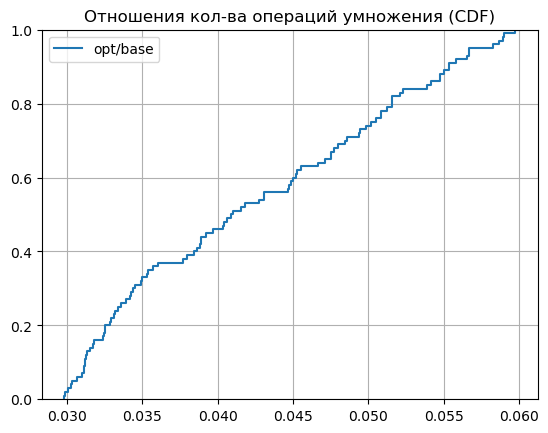

In [24]:
plt.title("Отношения кол-ва операций умножения (CDF)")
plt.ecdf(multiplications_opt_to_base, label="opt/base")
# plt.title("Number of '^=c*' operations (CDF)")
# plt.ecdf(multiplications_base, label="base")
# plt.ecdf(multiplications_opt, label="opt")
plt.grid(True)
plt.legend()
plt.gcf().savefig("multiplications_opt_to_base.png")
plt.show()

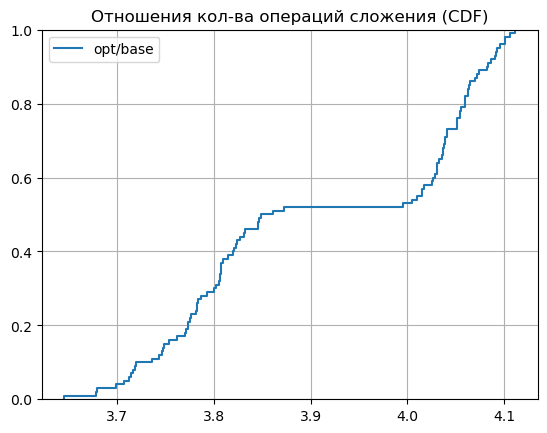

In [25]:
plt.title("Отношения кол-ва операций сложения (CDF)")
plt.ecdf(additions_opt_to_base, label="opt/base")
# plt.title("Number of '+=' operations (CDF)")
# plt.ecdf(additions_base, label="base")
# plt.ecdf(additions_opt, label="opt")
plt.grid(True)
plt.legend()
plt.gcf().savefig("additions_opt_to_base")
plt.show()

<>:3: DeprecationWarning: invalid escape sequence '\i'
<>:3: DeprecationWarning: invalid escape sequence '\i'
/tmp/ipykernel_66496/2047294473.py:3: DeprecationWarning: invalid escape sequence '\i'
  fig.suptitle("Сравнение числа операций при вычислении коэффициентов синдрома ($k \in [250; 500], r \in [10; 20]$)")


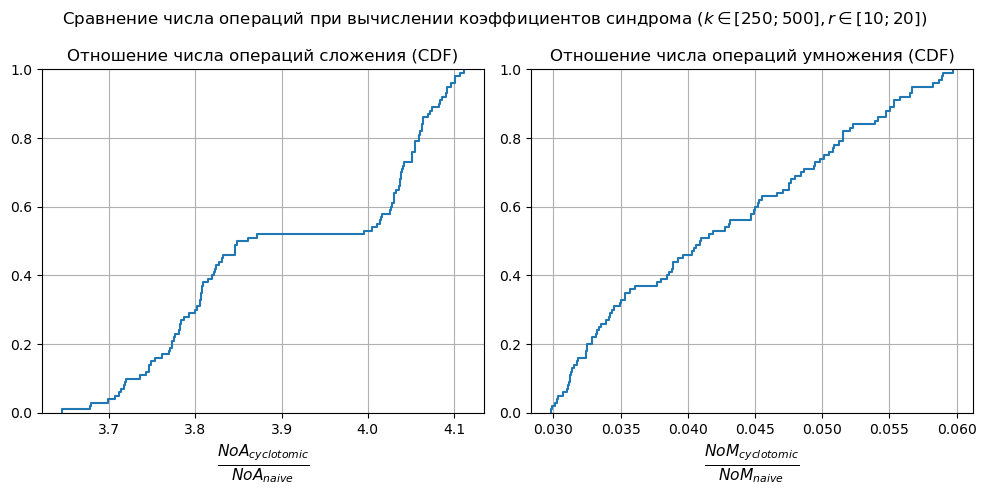

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Сравнение числа операций при вычислении коэффициентов синдрома ($k \in [250; 500], r \in [10; 20]$)")

axs[0].set_title("Отношение числа операций сложения (CDF)")
axs[0].ecdf(additions_opt_to_base, label="cyclotomic/naive")
axs[0].set_xlabel(r"$\frac{NoA_{cyclotomic}}{NoA_{naive}}$", fontsize=16)
axs[0].grid(True)
# axs[0].legend()

axs[1].set_title("Отношение числа операций умножения (CDF)")
axs[1].ecdf(multiplications_opt_to_base, label="cyclotomic/naive")
axs[1].set_xlabel(r"$\frac{NoM_{cyclotomic}}{NoM_{naive}}$", fontsize=16)
axs[1].grid(True)
# axs[1].legend()

fig.tight_layout()

fig.savefig("s_additions_and_multiplications_opt_to_base.png")

plt.show()

In [27]:
# plt.title("Ratio 'add_opt/mul_base' (CDF)")
# plt.ecdf(list(map(lambda t: t[0] / t[1], zip(additions_opt, multiplications_base))))
# plt.grid(True)
# plt.show()

In [28]:
r = random.randint(10, 50)
positions_cnt = random.randint(100, 255)
positions = sorted(random.sample(range(N), positions_cnt))
# positions_cnt = random.randint(100, 255) + 2
# positions = sorted(random.sample(range(N), positions_cnt - 2) + cyclotomic_cosets_by_size[2][0])

f = [F.random_element() for _ in range(positions_cnt)]

dft_base, counters_base = discrete_fourier_transform_f_base(r, positions, f)
dft_opt, counters_opt = discrete_fourier_transform_f_opt(r, positions, f)
# dft_cycl, counters_cycl = discrete_fourier_transform_f_cycl(r, positions, f)

assert dft_base == dft_opt
# assert dft_base == dft_cycl
print("r =", r, "positions_cnt =", positions_cnt)
print("Base:", counters_base)
print("Opt:", counters_opt)
# print("Cycl:", counters_cycl)

r = 50 positions_cnt = 113
Base: (5650, 5650)
Opt: (22677, 785)


### Tests for C code

In [29]:
def generate_test_code_f(symbol_size, r, positions_cnt):
    def symbol_seq_to_struct_init(s, symbol_size, l):
        # s is transposed relative to C code repr
        return "{" + ", ".join(
        "{" + ", ".join(
            str(s[i][j].to_integer()) 
            for i in range(symbol_size)
        ) + "}" 
        for j in range(l)
    ) + "}"
    
    def symbols_data_to_symbols(data_name, l):
        return "{" + ", ".join(
            f"{{.data = {data_name}[{i}]}}"
            for i in range(l)
        ) + "}"
    
    positions = random.sample(range(N), positions_cnt)
    f = [[F.random_element() for _ in range(positions_cnt)] for _ in range(symbol_size)]

    dft_base = [None] * symbol_size
    counters_base = [None] * symbol_size
    dft_opt = [None] * symbol_size
    counters_opt = [None] * symbol_size

    for i in range(symbol_size):
        dft_base[i], counters_base[i] = discrete_fourier_transform_f_base(r, positions, f[i])
        dft_opt[i], counters_opt[i] = discrete_fourier_transform_f_opt(r, positions, f[i])

        assert dft_base[i] == dft_opt[i]
    
    print("positions = ", positions)

    print("Base:", counters_base)
    print("Opt:", counters_opt)
    
    f_symbols_data = symbol_seq_to_struct_init(f, symbol_size, positions_cnt)
    res_symbols_data = symbol_seq_to_struct_init(dft_base, symbol_size, r)
    f_symbols = symbols_data_to_symbols("f_symbols_data", positions_cnt)
    res_symbols = symbols_data_to_symbols("res_symbols_data", r)
    positions_str = "{" + ", ".join(map(str, positions)) + "}"
        
    test_code = f"""{{
    element_t f_symbols_data[{positions_cnt}][{symbol_size}] = {f_symbols_data};
    element_t res_symbols_data[{r}][{symbol_size}] = {res_symbols_data};
    symbol_t f_symbols[{positions_cnt}] = {f_symbols};
    symbol_t res_symbols[{r}] = {res_symbols}; 
    symbol_seq_t f = {{.symbol_size = {symbol_size}, .length = {positions_cnt}, .symbols = f_symbols}};
    symbol_seq_t res = {{.symbol_size = {symbol_size}, .length = {r}, .symbols = res_symbols}};
    uint16_t positions[{positions_cnt}] = {positions_str};

    TEST_WRAPPER(fft, f, positions, res);
}}"""
    
    print("Test code:\n" + test_code)

In [30]:
# Test 1

symbol_size = 1
r = random.randint(10, 20)
positions_cnt = random.randint(10, 20)

generate_test_code_f(symbol_size, r, positions_cnt)

positions =  [62167, 2934, 46933, 5724, 17276, 2383, 49170, 41268, 63649, 54369]
Base: [(200, 200)]
Opt: [(800, 305)]
Test code:
{
    element_t f_symbols_data[10][1] = {{57327}, {17353}, {45354}, {62856}, {37265}, {13478}, {18119}, {43452}, {25564}, {51324}};
    element_t res_symbols_data[20][1] = {{14696}, {8593}, {4335}, {30421}, {61293}, {40959}, {36717}, {35417}, {23223}, {59295}, {41524}, {63919}, {48850}, {33564}, {51534}, {56530}, {19663}, {34499}, {26094}, {24364}};
    symbol_t f_symbols[10] = {{.data = f_symbols_data[0]}, {.data = f_symbols_data[1]}, {.data = f_symbols_data[2]}, {.data = f_symbols_data[3]}, {.data = f_symbols_data[4]}, {.data = f_symbols_data[5]}, {.data = f_symbols_data[6]}, {.data = f_symbols_data[7]}, {.data = f_symbols_data[8]}, {.data = f_symbols_data[9]}};
    symbol_t res_symbols[20] = {{.data = res_symbols_data[0]}, {.data = res_symbols_data[1]}, {.data = res_symbols_data[2]}, {.data = res_symbols_data[3]}, {.data = res_symbols_data[4]}, {.data = re

In [31]:
# Test 2

symbol_size = 2
r = random.randint(5, 15)
positions_cnt = random.randint(5, 15)

generate_test_code_f(symbol_size, r, positions_cnt)

positions =  [19149, 18140, 15770, 23387, 46372, 50032, 20385, 4007, 14395, 9139, 40227, 56905]
Base: [(120, 120), (120, 120)]
Opt: [(514, 145), (514, 145)]
Test code:
{
    element_t f_symbols_data[12][2] = {{42277, 27746}, {3127, 59115}, {9375, 15021}, {1097, 53154}, {6082, 58757}, {26142, 3437}, {32520, 60889}, {37630, 23859}, {37877, 57106}, {11473, 58389}, {5350, 52596}, {37950, 26470}};
    element_t res_symbols_data[10][2] = {{10770, 46737}, {26582, 62703}, {31312, 40301}, {30564, 52069}, {54007, 13446}, {36736, 10635}, {50527, 25447}, {32960, 36412}, {42346, 31111}, {43766, 37298}};
    symbol_t f_symbols[12] = {{.data = f_symbols_data[0]}, {.data = f_symbols_data[1]}, {.data = f_symbols_data[2]}, {.data = f_symbols_data[3]}, {.data = f_symbols_data[4]}, {.data = f_symbols_data[5]}, {.data = f_symbols_data[6]}, {.data = f_symbols_data[7]}, {.data = f_symbols_data[8]}, {.data = f_symbols_data[9]}, {.data = f_symbols_data[10]}, {.data = f_symbols_data[11]}};
    symbol_t res_symb

In [32]:
# Test 3

symbol_size = 3
r = random.randint(5, 10)
positions_cnt = random.randint(5, 10)

generate_test_code_f(symbol_size, r, positions_cnt)

positions =  [58527, 60312, 55345, 48945, 25091, 31786, 40267]
Base: [(42, 42), (42, 42), (42, 42)]
Opt: [(167, 81), (167, 81), (167, 81)]
Test code:
{
    element_t f_symbols_data[7][3] = {{42550, 26156, 7039}, {16493, 62153, 20108}, {51133, 41507, 46844}, {35359, 33510, 21322}, {8729, 65112, 15464}, {17649, 34735, 31275}, {65415, 36096, 47613}};
    element_t res_symbols_data[6][3] = {{12950, 16599, 20475}, {21627, 5559, 58156}, {42389, 10689, 15718}, {21632, 18861, 48795}, {15704, 4764, 16076}, {61380, 3743, 34329}};
    symbol_t f_symbols[7] = {{.data = f_symbols_data[0]}, {.data = f_symbols_data[1]}, {.data = f_symbols_data[2]}, {.data = f_symbols_data[3]}, {.data = f_symbols_data[4]}, {.data = f_symbols_data[5]}, {.data = f_symbols_data[6]}};
    symbol_t res_symbols[6] = {{.data = res_symbols_data[0]}, {.data = res_symbols_data[1]}, {.data = res_symbols_data[2]}, {.data = res_symbols_data[3]}, {.data = res_symbols_data[4]}, {.data = res_symbols_data[5]}}; 
    symbol_seq_t f = {

## $\tilde{\mathcal{F}}_{\Omega, d}(f) - \text{computes $F_j = f(a^j)$, $j \in \Omega$ for any polynomial $f(x)$ of degree $d-1$}$

### Implementation

In [33]:
def discrete_fourier_transform_f1_base(components, d, f):
    assert len(components) <= N
    assert d == len(f)
    
    op = Op()
    
    dft = [0 for _ in range(len(components))]
    
    for j, comp in enumerate(components):
        for i, f_i in enumerate(f):
            dft[j] = op.add(dft[j], op.mul(f_i, a^(i * comp)))
    
    return dft, op.counters()

In [34]:
def discrete_fourier_transform_f1_opt(components, d, f):
    assert len(components) <= N
    assert d == len(f)
    
    op = Op()
    
    dft_d = defaultdict(lambda: 0)
    calculated_d = defaultdict(lambda: False)
    
    for s in components:
        if calculated_d[s]:
            continue
            
        m = s_to_m[s]
        
        u_s = [0 for _ in range(m)]
        for t in range(m):
            for i, f_i in enumerate(f):
                a_s_t_i = A_s_t_i(s, t, i) # A_s_t_i(s, t, i) in {0, 1}
                if a_s_t_i == 1:
                    u_s[t] = op.add(u_s[t], f_i)
        
        b_s = [0 for _ in range(m)]
        
        g_s = [0 for _ in range(m)]
        for i in range(m):
            g_s[i] = normal_basis_by_m[m][(m - i) % m]

        idx = s
        for j in range(m):
            if idx in components:
                for t in range(m):
                    b_s[j] = op.add(b_s[j], op.mul(u_s[t], g_s[(2 * m - j - t) % m]))
            idx = (idx * 2) % N
        
        idx = s
        for i in range(m):
            if idx in components:
                dft_d[idx] = b_s[i]
                calculated_d[idx] = True
            idx = (idx * 2) % N
    
    dft = [dft_d[comp] for comp in components]
    
    return dft, op.counters()

In [35]:
def discrete_fourier_transform_f1_cycl(components, d, f):
    assert len(components) <= N
    assert d == len(f)
    
    op = Op()
    
    dft_d = defaultdict(lambda: 0)
    calculated_d = defaultdict(lambda: False)
    
    for s in components:
        if calculated_d[s]:
            continue
            
        m = s_to_m[s]
        
        u_s = [0 for _ in range(m)]
        for t in range(m):
            for i, f_i in enumerate(f):
                a_s_t_i = A_s_t_i(s, t, i) # A_s_t_i(s, t, i) in {0, 1}
                if a_s_t_i == 1:
                    u_s[t] = op.add(u_s[t], f_i)
        
        b_s = [0 for _ in range(m)]
        
        if m in cycl_m:
            P, R = P_m[m], R_m[m]
            
            Vf = [0 for _ in range(len(R))]
            for i, R_row in enumerate(R):
                for j in range(m):
                    if R_row[j] == 1:
                        Vf[i] = op.add(Vf[i], u_s[j])
            dVf = [op.mul(d_m[m][i], Vf[i]) for i in range(len(R))]
            
            for i, P_row in enumerate(P):
                for j in range(len(dVf)):
                    if P_row[j] == 1:
                        b_s[i] = op.add(b_s[i], dVf[j])
        else:
            g_s = [0 for _ in range(m)]
            for i in range(m):
                g_s[i] = normal_basis_by_m[m][(m - i) % m]
            
            idx = s
            for j in range(m):
                if idx in components:
                    for t in range(m):
                        b_s[j] = op.add(b_s[j], op.mul(u_s[t], g_s[(2 * m - j - t) % m]))
                idx = (idx * 2) % N
        
        idx = s
        for i in range(m):
            if idx in components:
                dft_d[idx] = b_s[i]
                calculated_d[idx] = True
            idx = (idx * 2) % N
    
    dft = [dft_d[comp] for comp in components]
    
    return dft, op.counters()

### Tests

In [47]:
cases = 100

additions_1_opt_to_base = []
additions_1_cycl_to_base = []
multiplications_1_opt_to_base = []
multiplications_1_cycl_to_base = []

for c in range(1, cases + 1):
    if c % 10 == 0:
        print("Running test", c)
    
    components = random.choice(cyclotomic_cosets_by_size[1]) + \
                    random.choice(cyclotomic_cosets_by_size[2]) + \
                    random.choice(cyclotomic_cosets_by_size[4]) + \
                    random.choice(cyclotomic_cosets_by_size[8][:15]) + \
                    random.choice(cyclotomic_cosets_by_size[8][15:]) + \
                    random.choice(cyclotomic_cosets_by_size[16][:2000]) + \
                    random.choice(cyclotomic_cosets_by_size[16][2000:])
    # for _ in range(9):
    #     comp = random.randint(0, N-1)
    #     if comp not in components:
    #         components.append(comp)
    # random.shuffle(components)
    
    # d = random.randint(10, 20)
    d = len(components)
    f = [F.random_element() for _ in range(d)]
    
    dft_base, counters_base = discrete_fourier_transform_f1_base(components, d, f)
    dft_opt, counters_opt = discrete_fourier_transform_f1_opt(components, d, f)
    dft_cycl, counters_cycl = discrete_fourier_transform_f1_cycl(components, d, f)
    assert dft_base == dft_opt
    assert dft_base == dft_cycl
    
    additions_1_opt_to_base.append(counters_opt[0] / counters_base[0])
    additions_1_cycl_to_base.append(counters_cycl[0] / counters_base[0])
    multiplications_1_opt_to_base.append(counters_opt[1] / counters_base[1])
    multiplications_1_cycl_to_base.append(counters_cycl[1] / counters_base[1])

print("Tests completed")

Running test 10
Running test 20
Running test 30
Running test 40
Running test 50
Running test 60
Running test 70
Running test 80
Running test 90
Running test 100
Tests completed


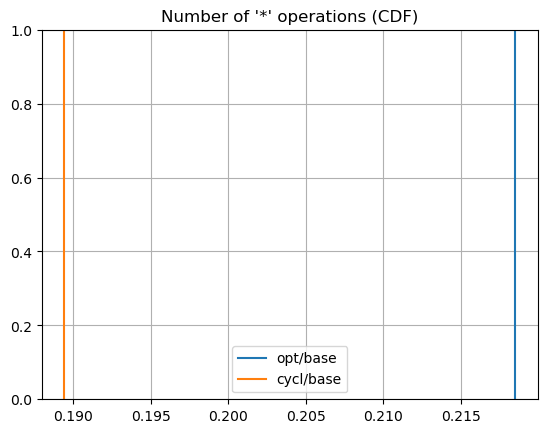

In [48]:
plt.title("Number of '*' operations (CDF)")
plt.ecdf(multiplications_1_opt_to_base, label="opt/base")
plt.ecdf(multiplications_1_cycl_to_base, label="cycl/base")
plt.grid(True)
plt.legend()
plt.show()

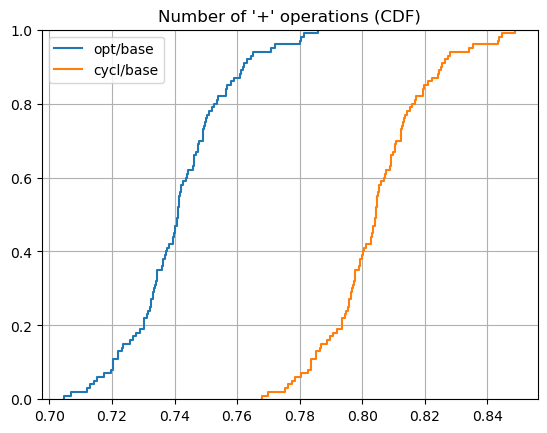

In [49]:
plt.title("Number of '+' operations (CDF)")
plt.ecdf(additions_1_opt_to_base, label="opt/base")
plt.ecdf(additions_1_cycl_to_base, label="cycl/base")
plt.grid(True)
plt.legend()
plt.show()

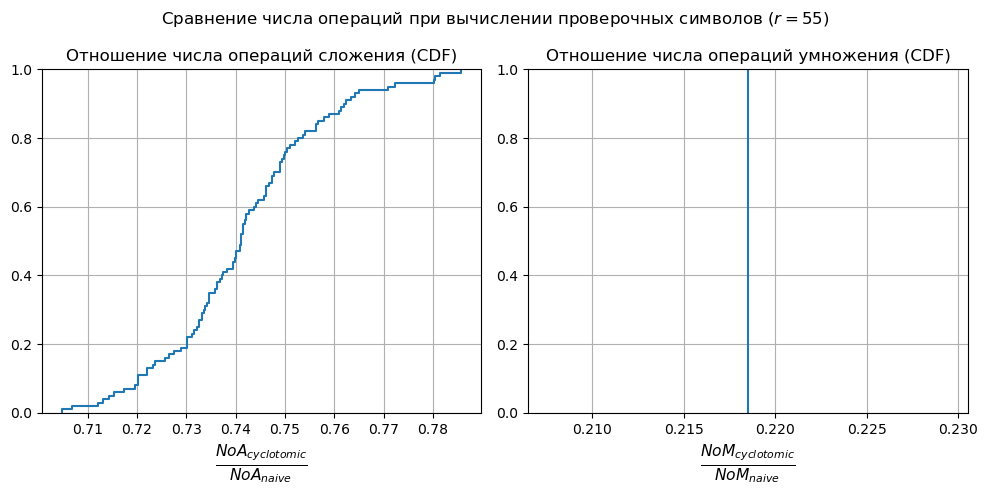

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Сравнение числа операций при вычислении проверочных символов ($r = 55$)")

axs[0].set_title("Отношение числа операций сложения (CDF)")
axs[0].ecdf(additions_1_opt_to_base)
axs[0].set_xlabel(r"$\frac{NoA_{cyclotomic}}{NoA_{naive}}$", fontsize=16)
axs[0].grid(True)
# axs[0].legend()

axs[1].set_title("Отношение числа операций умножения (CDF)")
axs[1].ecdf(multiplications_1_opt_to_base)
axs[1].set_xlabel(r"$\frac{NoM_{cyclotomic}}{NoM_{naive}}$", fontsize=16)
axs[1].grid(True)
# axs[1].legend()

fig.tight_layout()

fig.savefig("gamma_additions_and_multiplications_opt_to_base.png")

plt.show()

In [41]:
components = cyclotomic_cosets_by_size[8][0]
d = 200
f = [F.random_element() for _ in range(d)]

dft_base, counters_base = discrete_fourier_transform_f1_base(components, d, f)
dft_opt, counters_opt = discrete_fourier_transform_f1_opt(components, d, f)
dft_cycl, counters_cycl = discrete_fourier_transform_f1_cycl(components, d, f)

# print(dft_base[:5])
# print(dft_cycl[:5])

assert dft_base == dft_opt
assert dft_base == dft_cycl
print("components_cnt =", len(components), "d =", d)
print("Base:", counters_base)
print("Opt:", counters_opt)
print("Cycl:", counters_cycl)

components_cnt = 8 d = 200
Base: (1600, 1600)
Opt: (874, 64)
Cycl: (954, 24)


### Tests for C code

In [42]:
def generate_test_code_f1(symbol_size, d):
    def symbol_seq_to_struct_init(s, symbol_size, l):
        # s is transposed relative to C code repr
        return "{" + ", ".join(
        "{" + ", ".join(
            str(s[i][j].to_integer()) 
            for i in range(symbol_size)
        ) + "}" 
        for j in range(l)
    ) + "}"
    
    def symbols_data_to_symbols(data_name, l):
        return "{" + ", ".join(
            f"{{.data = {data_name}[{i}]}}"
            for i in range(l)
        ) + "}"
    
    coset_sizes = random.sample([1, 2, 4, 8, 16], 3)
    components = []
    for m in coset_sizes:
        components.extend(random.choice(cyclotomic_cosets_by_size[m]))
    for _ in range(3):
        comp = random.randint(0, N-1)
        if comp not in components:
            components.append(comp)
    random.shuffle(components)
    
    # C function have a bit different interface
    components_to_f1 = [(N - c) % N for c in components]
    
    f = [[F.random_element() for _ in range(d)] for _ in range(symbol_size)]

    dft_base = [None] * symbol_size
    counters_base = [None] * symbol_size
    dft_opt = [None] * symbol_size
    counters_opt = [None] * symbol_size

    for i in range(symbol_size):
        dft_base[i], counters_base[i] = discrete_fourier_transform_f1_base(components_to_f1, d, f[i])
        dft_opt[i], counters_opt[i] = discrete_fourier_transform_f1_opt(components_to_f1, d, f[i])

        assert dft_base[i] == dft_opt[i]
    
    print("positions = ", positions)

    print("Base:", counters_base)
    print("Opt:", counters_opt)
    
    f_symbols_data = symbol_seq_to_struct_init(f, symbol_size, d)
    res_symbols_data = symbol_seq_to_struct_init(dft_base, symbol_size, len(components))
    f_symbols = symbols_data_to_symbols("f_symbols_data", d)
    res_symbols = symbols_data_to_symbols("res_symbols_data", len(components))
    components_str = "{" + ", ".join(map(str, components)) + "}"
        
    test_code = f"""{{
    element_t f_symbols_data[{d}][{symbol_size}] = {f_symbols_data};
    element_t res_symbols_data[{len(components)}][{symbol_size}] = {res_symbols_data};
    symbol_t f_symbols[{d}] = {f_symbols};
    symbol_t res_symbols[{len(components)}] = {res_symbols}; 
    symbol_seq_t f = {{.symbol_size = {symbol_size}, .length = {d}, .symbols = f_symbols}};
    symbol_seq_t res = {{.symbol_size = {symbol_size}, .length = {len(components)}, .symbols = res_symbols}};
    uint16_t components[{len(components)}] = {components_str};

    TEST_WRAPPER(fft, f, res, components);
}}"""
    
    print("Test code:\n" + test_code)

In [43]:
# Test 1

symbol_size = 1
d = random.randint(15, 25)

generate_test_code_f1(symbol_size, d)

positions =  [253, 426, 1317, 2011, 2287, 3701, 4899, 4979, 6417, 6551, 7165, 7386, 7404, 8012, 8169, 8700, 8929, 9169, 10259, 10412, 11591, 11911, 11912, 12149, 12451, 12755, 14140, 15137, 15347, 16614, 17048, 17214, 17456, 17734, 17832, 18391, 18926, 19004, 20302, 20883, 21515, 21823, 22252, 26038, 27748, 28018, 28136, 28178, 29403, 30690, 30751, 30905, 31305, 31713, 33062, 33292, 33575, 33999, 34379, 34723, 35351, 36282, 36327, 37280, 37377, 38603, 38773, 38895, 39327, 41029, 41178, 41209, 42281, 43449, 44499, 44605, 45062, 45474, 45534, 46195, 46736, 47012, 47521, 48253, 48625, 48921, 51112, 51216, 51223, 52122, 52578, 52729, 53572, 54354, 54802, 54893, 55083, 55398, 56245, 57109, 57363, 57778, 57867, 58274, 58445, 58458, 58672, 61095, 61343, 61464, 63336, 63554, 65513]
Base: [(272, 272)]
Opt: [(600, 121)]
Test code:
{
    element_t f_symbols_data[17][1] = {{4303}, {25741}, {32850}, {30262}, {57412}, {30445}, {14933}, {33264}, {63797}, {9636}, {15121}, {15806}, {58029}, {61674}, {5

In [44]:
# Test 2

symbol_size = 2
d = random.randint(10, 15)

generate_test_code_f1(symbol_size, d)

positions =  [253, 426, 1317, 2011, 2287, 3701, 4899, 4979, 6417, 6551, 7165, 7386, 7404, 8012, 8169, 8700, 8929, 9169, 10259, 10412, 11591, 11911, 11912, 12149, 12451, 12755, 14140, 15137, 15347, 16614, 17048, 17214, 17456, 17734, 17832, 18391, 18926, 19004, 20302, 20883, 21515, 21823, 22252, 26038, 27748, 28018, 28136, 28178, 29403, 30690, 30751, 30905, 31305, 31713, 33062, 33292, 33575, 33999, 34379, 34723, 35351, 36282, 36327, 37280, 37377, 38603, 38773, 38895, 39327, 41029, 41178, 41209, 42281, 43449, 44499, 44605, 45062, 45474, 45534, 46195, 46736, 47012, 47521, 48253, 48625, 48921, 51112, 51216, 51223, 52122, 52578, 52729, 53572, 54354, 54802, 54893, 55083, 55398, 56245, 57109, 57363, 57778, 57867, 58274, 58445, 58458, 58672, 61095, 61343, 61464, 63336, 63554, 65513]
Base: [(288, 288), (288, 288)]
Opt: [(793, 321), (793, 321)]
Test code:
{
    element_t f_symbols_data[12][2] = {{15699, 47188}, {4943, 33982}, {33217, 26207}, {25974, 50982}, {34493, 42227}, {18825, 27265}, {9103, 

In [45]:
# Test 3

symbol_size = 3
d = random.randint(5, 10)

generate_test_code_f1(symbol_size, d)

positions =  [253, 426, 1317, 2011, 2287, 3701, 4899, 4979, 6417, 6551, 7165, 7386, 7404, 8012, 8169, 8700, 8929, 9169, 10259, 10412, 11591, 11911, 11912, 12149, 12451, 12755, 14140, 15137, 15347, 16614, 17048, 17214, 17456, 17734, 17832, 18391, 18926, 19004, 20302, 20883, 21515, 21823, 22252, 26038, 27748, 28018, 28136, 28178, 29403, 30690, 30751, 30905, 31305, 31713, 33062, 33292, 33575, 33999, 34379, 34723, 35351, 36282, 36327, 37280, 37377, 38603, 38773, 38895, 39327, 41029, 41178, 41209, 42281, 43449, 44499, 44605, 45062, 45474, 45534, 46195, 46736, 47012, 47521, 48253, 48625, 48921, 51112, 51216, 51223, 52122, 52578, 52729, 53572, 54354, 54802, 54893, 55083, 55398, 56245, 57109, 57363, 57778, 57867, 58274, 58445, 58458, 58672, 61095, 61343, 61464, 63336, 63554, 65513]
Base: [(102, 102), (102, 102), (102, 102)]
Opt: [(335, 132), (335, 132), (335, 132)]
Test code:
{
    element_t f_symbols_data[6][3] = {{60985, 64775, 6894}, {44976, 20641, 48345}, {6088, 19856, 59859}, {19530, 1441